In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 14.8 MB/s eta 0:00:00a 0:00:01


# Complete Architecture

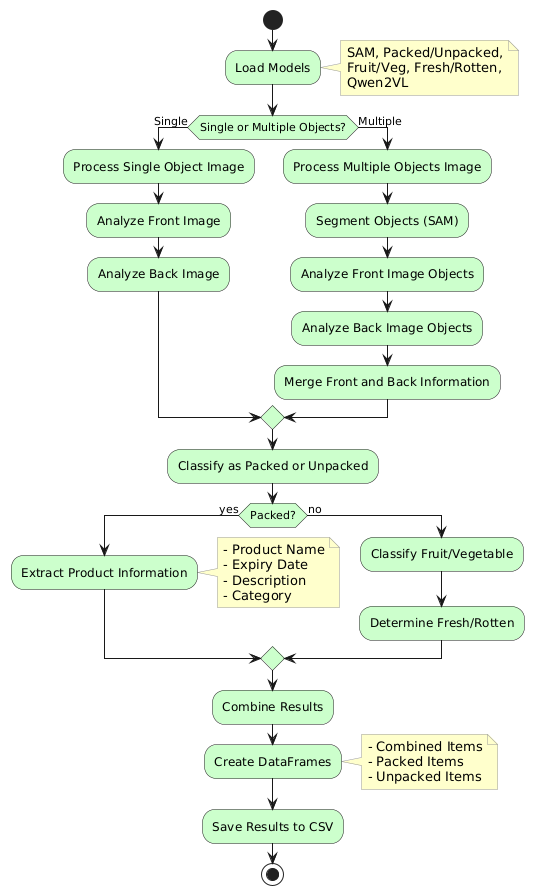

# TRY IT OUT

# TESTING IMAGE



**FRONT** 

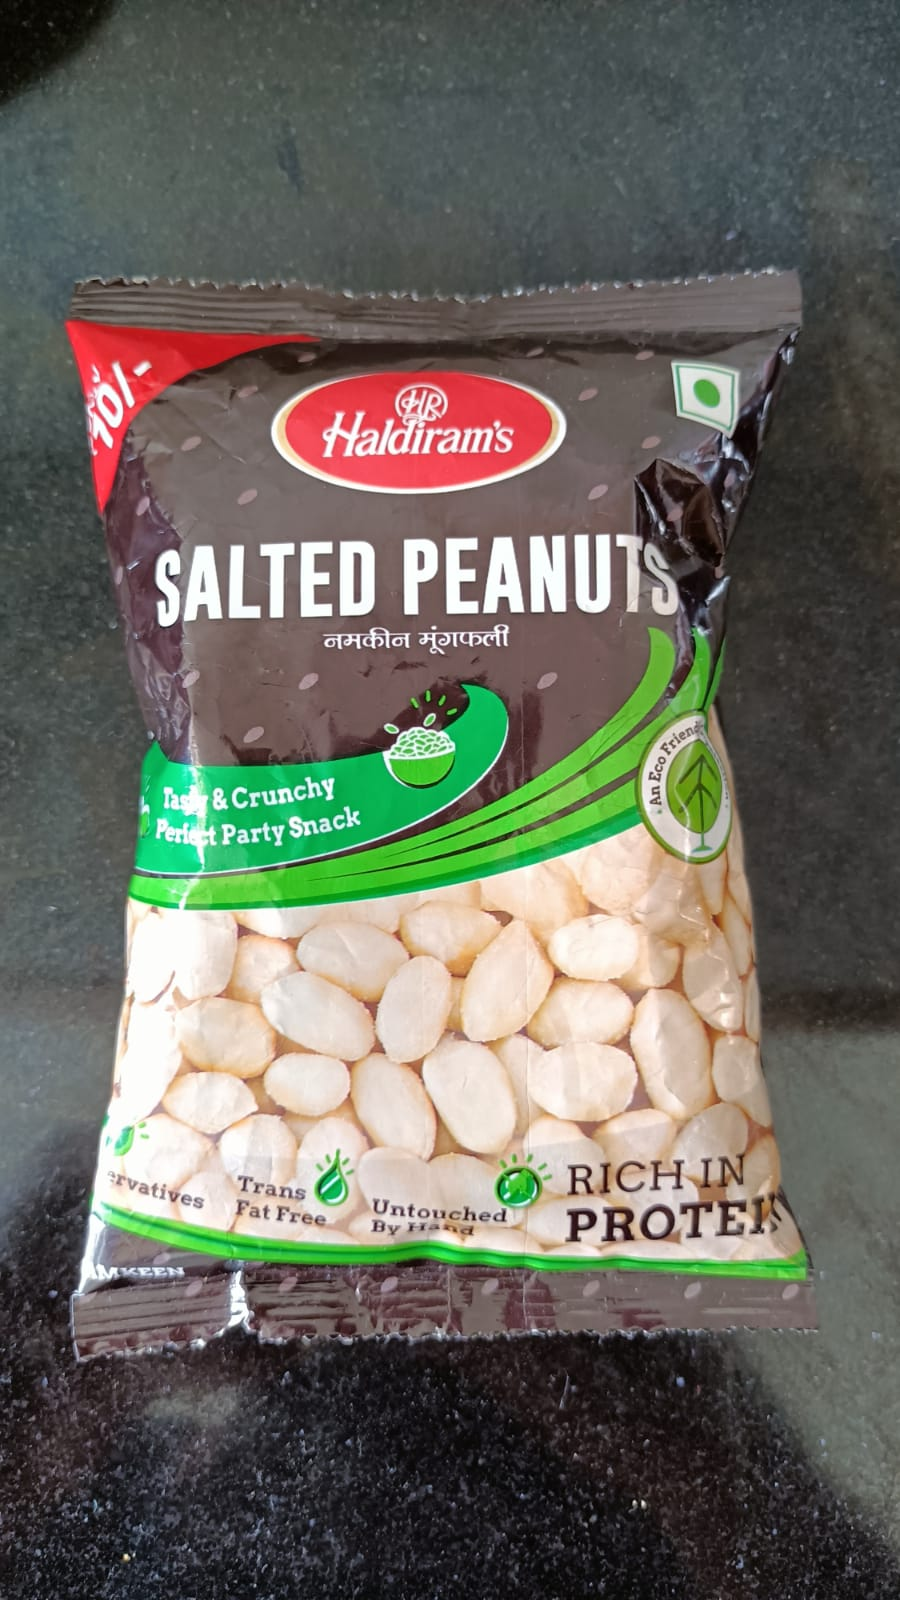!


**BACK**

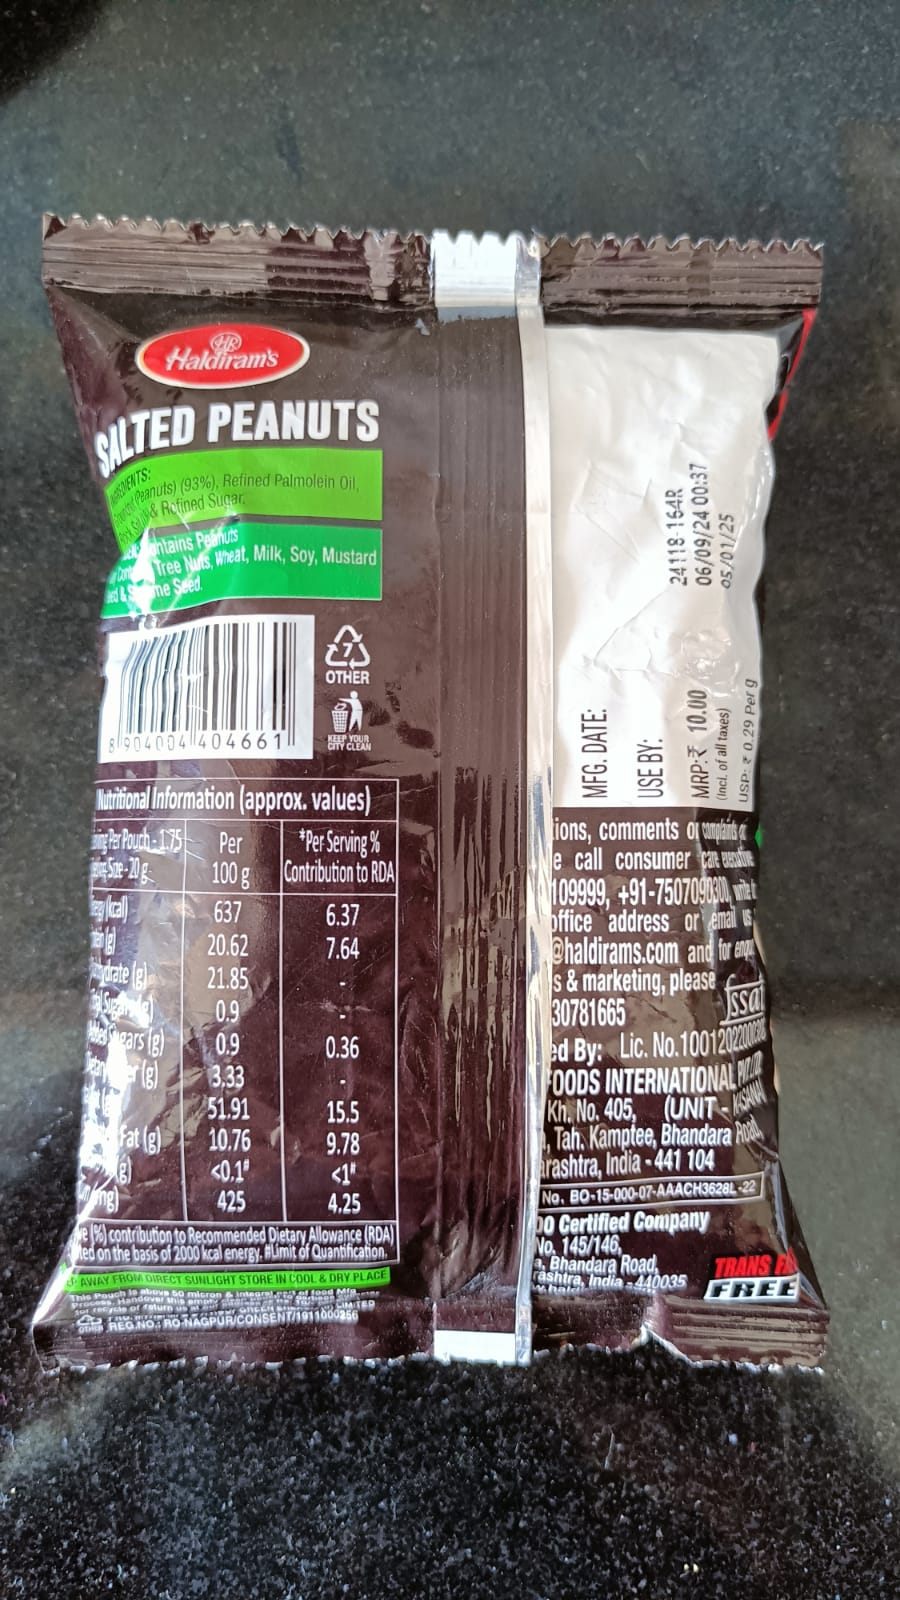

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from ultralytics import SAM
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import jaccard_score
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
import warnings
import re
from datetime import datetime

# Suppress warnings
warnings.filterwarnings("ignore")

# Ensure GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper functions
def iou(mask1, mask2):
    return jaccard_score(mask1.flatten(), mask2.flatten())

def place_on_white_background(image):
    white_bg = np.ones_like(image) * 255
    mask = np.any(image != [0, 0, 0], axis=-1)
    white_bg[mask] = image[mask]
    return white_bg

def process_sam_results(results, model_name, iou_threshold=0.8, min_object_size=50):
    original_image = results[0].orig_img
    masks = results[0].masks.data.cpu().numpy()
    
    unique_objects = []
    for i, mask in enumerate(masks):
        is_unique = True
        for existing_obj in unique_objects:
            if iou(mask, existing_obj['mask']) > iou_threshold:
                is_unique = False
                break
        
        if is_unique:
            object_mask = mask.astype(bool)
            object_image = np.zeros_like(original_image)
            object_image[object_mask] = original_image[object_mask]
            
            y, x = np.where(object_mask)
            y1, y2, x1, x2 = y.min(), y.max(), x.min(), x.max()
            
            cropped_object = object_image[y1:y2, x1:x2]
            
            if cropped_object.shape[0] < min_object_size or cropped_object.shape[1] < min_object_size:
                continue
            
            object_on_white = place_on_white_background(cropped_object)
            
            object_filename = f"{model_name}object{len(unique_objects)}.png"
            cv2.imwrite(object_filename, cv2.cvtColor(object_on_white, cv2.COLOR_RGB2BGR))
            
            unique_objects.append({
                'model': model_name,
                'object_id': len(unique_objects),
                'image': Image.fromarray(object_on_white),
                'mask': mask,
                'bbox': [x1, y1, x2, y2],
                'filename': object_filename
            })
    
    return unique_objects

def visualize_objects(objects, cols=5):
    n = len(objects)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.flatten()
    
    for i, obj in enumerate(objects):
        axs[i].imshow(obj['image'])
        axs[i].axis('off')
        axs[i].set_title(f"Object {obj['object_id']}")
    
    for i in range(n, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load models
sam_model = SAM("sam2_b.pt")

packed_unpacked_model = models.efficientnet_b0(pretrained=False)
packed_unpacked_model.classifier[1] = nn.Linear(packed_unpacked_model.classifier[1].in_features, 2)
packed_unpacked_model.load_state_dict(torch.load('/kaggle/input/models-loaded/keras/default/1/efficientnet_b0_packed_unpacked (2).pth', map_location=device))
packed_unpacked_model.to(device)
packed_unpacked_model.eval()

fruit_veg_model = models.efficientnet_b0(pretrained=False)
fruit_veg_model.classifier[1] = nn.Linear(fruit_veg_model.classifier[1].in_features, 54)
fruit_veg_model.load_state_dict(torch.load('/kaggle/input/models-loaded/keras/default/1/efficientnet_b0_fruit_veg_1 (1).pth', map_location=device))
fruit_veg_model.to(device)
fruit_veg_model.eval()

fresh_rotten_model = models.efficientnet_b0(pretrained=False)
fresh_rotten_model.classifier[1] = nn.Linear(fresh_rotten_model.classifier[1].in_features, 2)
fresh_rotten_model.load_state_dict(torch.load('/kaggle/input/models-loaded/keras/default/1/efficientnet_b0_fruit_veg (2).pth', map_location=device))
fresh_rotten_model.to(device)
fresh_rotten_model.eval()

qwen_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype="auto",
    device_map="auto",
)
qwen_processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

# Define categories and transformations
packed_unpacked_categories = ['Packed', 'Unpacked']
packed_unpacked_idx_to_category = {idx: category for idx, category in enumerate(packed_unpacked_categories)}

fruit_veg_categories = [
    'Orange', 'Tamarillo', 'Lime', 'Pomegranate', 'Plum', 'Pineapple', 'Apple', 'Dates', 'Papaya', 'Guava',
    'Beetroot', 'Pear', 'Strawberry', 'Blueberry', 'Lulo', 'Avacado', 'Lemon', 'Kaki', 'Peach', 'Grape',
    'Banana', 'Cherry', 'Watermelon', 'Mango', 'Grapefruit', 'Broccoli', 'Capsicum', 'Radish', 'Tomato', 'Turnip',
    'Ginger', 'Zucchini', 'Brinjal', 'Pumpkin', 'Bell Pepper', 'Carrot', 'New Mexico Green Chile', 'Eggplant',
    'Baby Corn', 'Zucchini dark', 'Sweet corn', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Chile Pepper',
    'Sweet Potato', 'Bean', 'Cucumber', 'Bottle Gourd', 'Garlic', 'Peas', 'Onion', 'Potato', 'Spinach'
]
fruit_veg_idx_to_category = {idx: category for idx, category in enumerate(fruit_veg_categories)}

fresh_rotten_categories = ['Fresh', 'Rotten']
fresh_rotten_idx_to_category = {idx: category for idx, category in enumerate(fresh_rotten_categories)}

packed_categories = [
    'Staples', 'Snacks & Beverages', 'Packaged Food', 'Personal & Baby Care',
    'Household Care', 'Dairy & Eggs', 'Home & Kitchen'
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_image_class(model, image_path, idx_to_category):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image)
            _, predicted_label = torch.max(outputs, 1)

        predicted_label = predicted_label.item()
        predicted_category = idx_to_category[predicted_label]

        return predicted_label, predicted_category
    except Exception as e:
        print(f"Error predicting class for {image_path}: {str(e)}")
        return None, None

def get_product_info(image_path, question):
    try:
        image = Image.open(image_path)
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": question}
                ]
            }
        ]
        text_prompt = qwen_processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = qwen_processor(text=[text_prompt], images=[image], padding=True, return_tensors="pt")
        inputs = inputs.to("cuda")
        output_ids = qwen_model.generate(**inputs, max_new_tokens=1024)
        generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
        output_text = qwen_processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        return output_text[0]
    except Exception as e:
        print(f"Error getting product info for {image_path}: {str(e)}")
        return "Error: Unable to process image"

def is_valid_date(date_str):
    date_formats = [
        "%d/%m/%Y", "%d-%m-%Y", "%Y/%m/%d", "%Y-%m-%d", 
        "%m/%d/%Y", "%m-%d-%Y", "%d %b %Y", "%d %B %Y", 
        "%d/%m/%y", "%d-%m-%y", "%Y%m%d"
    ]
    for date_format in date_formats:
        try:
            datetime.strptime(date_str, date_format)
            return True
        except ValueError:
            continue
    return False

def process_single_object(image_path):
    # Check if packed or unpacked
    _, packed_unpacked_category = predict_image_class(packed_unpacked_model, image_path, packed_unpacked_idx_to_category)
    
    if packed_unpacked_category == 'Packed':
        # Get product information using Qwen model
        product_name = get_product_info(image_path, "What is the name of the product? NOTE: JUST PROVIDE NAME AS THE ANSWER")
        expiry_date = get_product_info(image_path, "What is the expiry date of the product. Note: JUST PROVIDE EXPIRY DATE AS THE ANSWER")
        description = get_product_info(image_path, "Provide a brief description of the product")
        category_info = get_product_info(image_path, "Classify the product into one of these categories: Staples, Snacks & Beverages, Packaged Food, Personal & Baby Care, Household Care, Dairy & Eggs, Home & Kitchen")
        return pd.DataFrame({
            'name': [product_name],
            'expiry_date': [expiry_date],
            'description': [description],
            'category': [category_info],
            'type': ['Packed'],
            'frequency': [1]
        })
    else:
        # Classify fruit/vegetable
        _, fruit_veg_category = predict_image_class(fruit_veg_model, image_path, fruit_veg_idx_to_category)
        
        # Determine if fresh or rotten
        _, fresh_rotten_category = predict_image_class(fresh_rotten_model, image_path, fresh_rotten_idx_to_category)
        
        return pd.DataFrame({
            'name': [fruit_veg_category],
            'condition': [fresh_rotten_category],
            'type': ['Unpacked'],
            'frequency': [1],
            'indepth_condition': ['To be determined'],  # Placeholder
            'weight': ['To be determined']  # Placeholder
        })

def process_multiple_objects(image_path, is_front):
    # Perform segmentation
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = sam_model(img)
    objects = process_sam_results(results, "sam")
    
    df_list = []
    for obj in objects:
        obj_image_path = obj['filename']
        obj_df = process_single_object(obj_image_path)
        obj_df['bbox'] = [obj['bbox']]
        obj_df['side'] = ['Front' if is_front else 'Back']
        df_list.append(obj_df)
    
    return pd.concat(df_list, ignore_index=True)

def main():
    image_type = input("Is this a single object image or multiple objects image? (single/multiple): ").lower()
    
    if image_type == 'single':
        front_image_path = input("Enter the path to the front image: ")
        back_image_path = input("Enter the path to the back image: ")
        
        front_df = process_single_object(front_image_path)
        front_df['side'] = 'Front'
        back_df = process_single_object(back_image_path)
        back_df['side'] = 'Back'
        
        combined_df = pd.concat([front_df, back_df], ignore_index=True)
        
    elif image_type == 'multiple':
        front_image_path = input("Enter the path to the front image: ")
        back_image_path = input("Enter the path to the back image: ")
        
        front_df = process_multiple_objects(front_image_path, is_front=True)
        back_df = process_multiple_objects(back_image_path, is_front=False)
        
        combined_df = pd.concat([front_df, back_df], ignore_index=True)
        
        # Instead of grouping by 'bbox', we'll create a unique identifier
        combined_df['object_id'] = range(len(combined_df))
        
        # Merge front and back information based on object overlap
        # This is a simplified approach and may need refinement
        merged_df = combined_df.groupby('object_id').first().reset_index()
        
    else:
        print("Invalid input. Please choose 'single' or 'multiple'.")
        return
    
    # Create separate DataFrames for packed and unpacked items
    packed_df = combined_df[combined_df['type'] == 'Packed']
    unpacked_df = combined_df[combined_df['type'] == 'Unpacked']
    
    # Save results
    combined_df.to_csv('combined_items.csv', index=False)
    packed_df.to_csv('packed_items.csv', index=False)
    unpacked_df.to_csv('unpacked_items.csv', index=False)
    
    print("Processing complete. Results saved to CSV files.")
    print("\nCombined items:")
    print(combined_df)
    print("\nPacked items:")
    print(packed_df)
    print("\nUnpacked items:")
    print(unpacked_df)

    
if __name__ == "__main__":
    main()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


100%|██████████| 154M/154M [00:03<00:00, 51.3MB/s] 


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Is this a single object image or multiple objects image? (single/multiple):  single
Enter the path to the front image:  /kaggle/input/final-dataset-testing/images/images/packed1-front.jpg
Enter the path to the back image:  /kaggle/input/final-dataset-testing/images/images/packed1-back.jpg


Processing complete. Results saved to CSV files.

Combined items:
                        name  \
0  Haldiram's Salted Peanuts   
1  Haldiram's Salted Peanuts   

                                         expiry_date  \
0  The expiry date of the product is not visible ...   
1        The expiry date of the product is 06/09/24.   

                                         description  \
0  The product is a bag of Haldiram's Salted Pean...   
1  The product is Haldiram's Salted Peanuts. It i...   

                                            category    type  frequency   side  
0  The product in the picture is a bag of **Salte...  Packed          1  Front  
1  The product in the image is a bag of "Haldiram...  Packed          1   Back  

Packed items:
                        name  \
0  Haldiram's Salted Peanuts   
1  Haldiram's Salted Peanuts   

                                         expiry_date  \
0  The expiry date of the product is not visible ...   
1        The expiry date of the 

# VIEWING THE DATA STORED

In [3]:
packed_df=pd.read_csv('/kaggle/working/packed_items.csv')
packed_df.head()

name  \
0  Haldiram's Salted Peanuts   
1  Haldiram's Salted Peanuts   

                                         expiry_date  \
0  The expiry date of the product is not visible ...   
1        The expiry date of the product is 06/09/24.   

                                         description  \
0  The product is a bag of Haldiram's Salted Pean...   
1  The product is Haldiram's Salted Peanuts. It i...   

                                            category    type  frequency   side  
0  The product in the picture is a bag of **Salte...  Packed          1  Front  
1  The product in the image is a bag of "Haldiram...  Packed          1   Back

In [4]:
unpacked_df=pd.read_csv('/kaggle/working/unpacked_items.csv')
unpacked_df

Empty DataFrame
Columns: [name, expiry_date, description, category, type, frequency, side]
Index: []

In [5]:
combined_df=pd.read_csv('/kaggle/working/combined_items.csv')
combined_df

name  \
0  Haldiram's Salted Peanuts   
1  Haldiram's Salted Peanuts   

                                         expiry_date  \
0  The expiry date of the product is not visible ...   
1        The expiry date of the product is 06/09/24.   

                                         description  \
0  The product is a bag of Haldiram's Salted Pean...   
1  The product is Haldiram's Salted Peanuts. It i...   

                                            category    type  frequency   side  
0  The product in the picture is a bag of **Salte...  Packed          1  Front  
1  The product in the image is a bag of "Haldiram...  Packed          1   Back

SMALLER OVERVIEW OF IT

It is working exceptionally well for the images having single object  and somewhat disturbed by the sam masks when given image having multiple objects 